In [89]:
 #Download Bitcoin historical data from GitHub
# Note: you'll need to select "Raw" to download the data in the correct format
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2024-03-20 16:26:34--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.3’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.03s   

2024-03-20 16:26:34 (6.57 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.3’ saved [178509/178509]



In [90]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [91]:
# Load dataset
prices_raw_df = pd.read_csv('BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv')
prices_raw_df.head()

Currency        Date  Closing Price (USD)  24h Open (USD)  24h High (USD)  \
0      BTC  2013-10-01            123.65499       124.30466       124.75166   
1      BTC  2013-10-02            125.45500       123.65499       125.75850   
2      BTC  2013-10-03            108.58483       125.45500       125.66566   
3      BTC  2013-10-04            118.67466       108.58483       118.67500   
4      BTC  2013-10-05            121.33866       118.67466       121.93633   

   24h Low (USD)  
0      122.56349  
1      123.63383  
2       83.32833  
3      107.05816  
4      118.00566

In [92]:
prices = pd.DataFrame({"date":prices_raw_df['Date'],
                       "price":prices_raw_df['Closing Price (USD)']})
prices.head()

date      price
0  2013-10-01  123.65499
1  2013-10-02  125.45500
2  2013-10-03  108.58483
3  2013-10-04  118.67466
4  2013-10-05  121.33866

<Axes: >

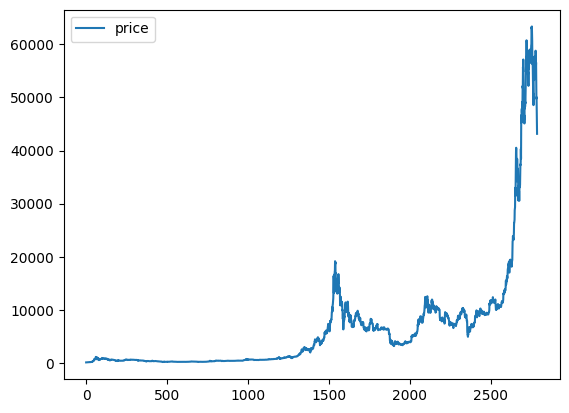

In [93]:
prices.plot()

In [94]:
split_time = 2000
time = prices['date'].to_numpy(dtype='datetime64[ns]')
series = prices['price'].to_numpy()

len(time), len(series), time[:2], series[:2]

(2787,
 2787,
 array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  ]))

In [95]:
split_time = 2000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]


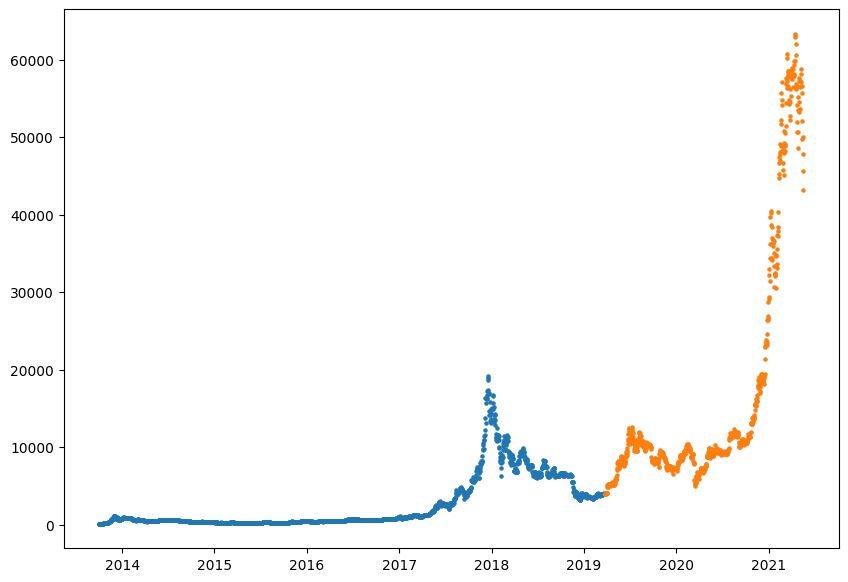

In [96]:
plt.figure(figsize=(10,7))
plt.scatter(time_train, x_train, s=5)
plt.scatter(time_valid, x_valid, s=5)

In [109]:
def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)


In [110]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [128]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      tf.keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(tf.keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))
optimizer = tf.keras.optimizers.Adam(lr=1e-4)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
16/16 [==============================] - 5s 103ms/step - loss: 2444.1606 - mae: 2444.6606 - lr: 1.0000e-04
Epoch 2/100
16/16 [==============================] - 1s 64ms/step - loss: 2323.0264 - mae: 2323.5264 - lr: 1.0798e-04
Epoch 3/100
16/16 [==============================] - 1s 69ms/step - loss: 2139.7390 - mae: 2140.2390 - lr: 1.1659e-04
Epoch 4/100
16/16 [==============================] - 1s 68ms/step - loss: 1840.3230 - mae: 1840.8230 - lr: 1.2589e-04
Epoch 5/100
16/16 [==============================] - 1s 67ms/step - loss: 1342.4883 - mae: 1342.9883 - lr: 1.3594e-04
Epoch 6/100
16/16 [==============================] - 1s 51ms/step - loss: 901.5275 - mae: 902.0270 - lr: 1.4678e-04
Epoch 7/100
16/16 [==============================] - 1s 51ms/step - loss: 783.2914 - mae: 783.7910 - lr: 1.5849e-04
Epoch 8/100
16/16 [==============================] - 1s 66ms/step - loss: 633.2412 - mae: 633.7400 - lr: 1.7113e-04
Epoch 9/100
16/16 [==============================] - 2s 102ms

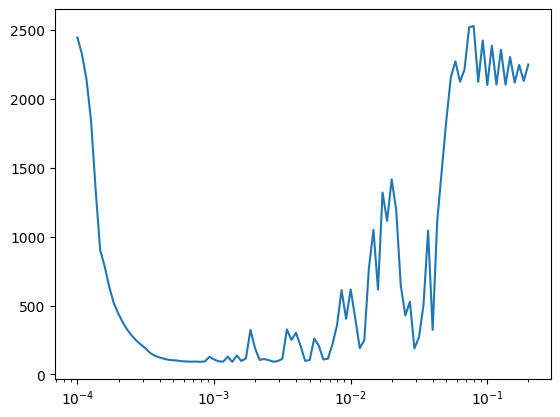

In [130]:
plt.semilogx(history.history["lr"], history.history["loss"], label="lr vs epoch")
#plt.axis([1e-8, 1e-1, 1000, 5000])

In [131]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      tf.keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(tf.keras.layers.Conv1D(filters=1, kernel_size=1))
optimizer = tf.keras.optimizers.Adam(lr=3e-4)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
16/16 [==============================] - 4s 106ms/step - loss: 2349.6372 - mae: 2350.1372 - val_loss: 11846.3213 - val_mae: 11846.8213


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/500
16/16 [==============================] - 2s 124ms/step - loss: 989.6584 - mae: 990.1582 - val_loss: 3663.6509 - val_mae: 3664.1509
Epoch 3/500
16/16 [==============================] - 1s 74ms/step - loss: 497.5784 - mae: 498.0774 - val_loss: 2165.6331 - val_mae: 2166.1331
Epoch 4/500
16/16 [==============================] - 1s 75ms/step - loss: 310.8242 - mae: 311.3221 - val_loss: 1382.9178 - val_mae: 1383.4177
Epoch 5/500
16/16 [==============================] - 2s 82ms/step - loss: 204.3283 - mae: 204.8253 - val_loss: 945.6683 - val_mae: 946.1682
Epoch 6/500
16/16 [==============================] - 1s 75ms/step - loss: 158.5860 - mae: 159.0812 - val_loss: 696.9820 - val_mae: 697.4817
Epoch 7/500
16/16 [==============================] - 1s 78ms/step - loss: 132.9995 - mae: 133.4933 - val_loss: 628.0240 - val_mae: 628.5237
Epoch 8/500
16/16 [==============================] - 2s 108ms/step - loss: 122.8069 - mae: 123.3007 - val_loss: 557.6576 - val_mae: 558.1571
Epoch 9/500


In [132]:
model = tf.keras.models.load_model('my_checkpoint.h5')

In [133]:
model.evaluate(valid_set)

6/6 [==============================] - 1s 31ms/step - loss: 438.8369 - mae: 439.3362


[438.8368835449219, 439.3361511230469]

In [144]:
forecast = model_forecast(model,  series[..., np.newaxis], window_size)

86/86 [==============================] - 1s 14ms/step


In [148]:
forecast = forecast[split_time - window_size:-1, -1, 0]

In [140]:
len(forecast), len(x_valid)

(787, 787)

In [152]:
tf.keras.metrics.mean_absolute_error(x_valid, forecast)

<tf.Tensor: shape=(), dtype=float32, numpy=479.08896>

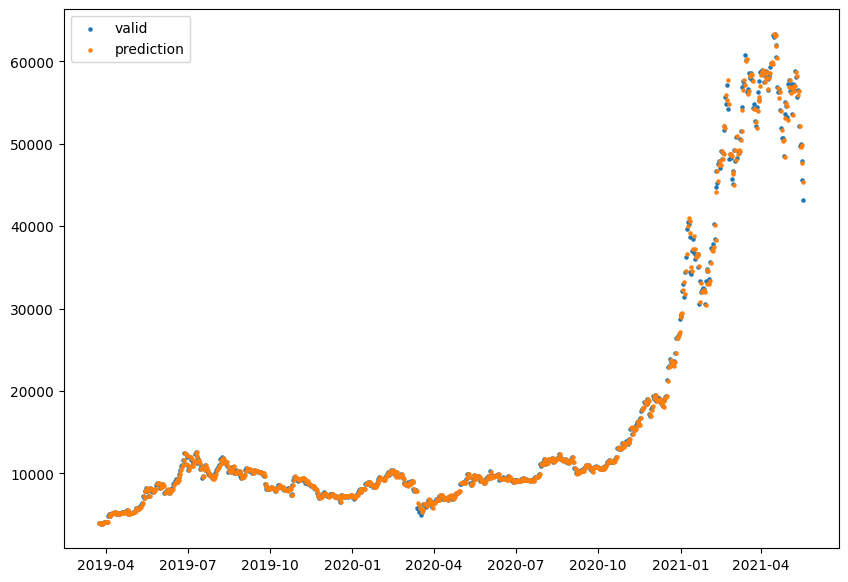

In [153]:
plt.figure(figsize=(10,7))
plt.scatter(time_valid, x_valid, s=5, label='valid')
plt.scatter(time_valid, forecast, s=5, label='prediction')
plt.legend()